In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

# Question 1

In [4]:
data = yf.download('DOT-USD', start='2020-09-01', end='2022-08-31') 

[*********************100%***********************]  1 of 1 completed


In [5]:
data_ac = data['Adj Close']
data_ac.head()

Date
2020-09-01    6.288767
2020-09-02    6.139465
2020-09-03    5.747868
2020-09-04    5.146038
2020-09-05    4.122313
Name: Adj Close, dtype: float64

### Statistical description of adjust close

In [6]:
data_ac.describe().round(2)

count    729.00
mean      20.13
std       12.60
min        3.76
25%        8.13
50%       18.34
75%       29.61
max       53.88
Name: Adj Close, dtype: float64

### Find the log return & annualysed volatility

1. Using data of 3 month period of June 2022-Aug 2022

In [7]:
data3 = data_ac[-91:-1]
data3.head()

Date
2022-06-01    9.471385
2022-06-02    9.897680
2022-06-03    9.376930
2022-06-04    9.430593
2022-06-05    9.344997
Name: Adj Close, dtype: float64

2. Log return for 3-month periods

In [245]:
log_return = np.log(data3/ data3.shift(1))
log_return.head().round(4)
Log_ret_mean = np.mean(log_return)
print('The log-return of Polka Dot from the 3month-annlysied period is', (Log_ret_mean))

The log-return of Polka Dot from the 3month-annlysied period is -0.0029528934240713772


3. Calculate its standard deviation and annualised it

In [9]:
vol = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 97.39 %


### Plot the movement of Polkadot over the time 2-year period of 01 Sep 2020 - 31 Aug 2022

array([<AxesSubplot: xlabel='Date'>], dtype=object)

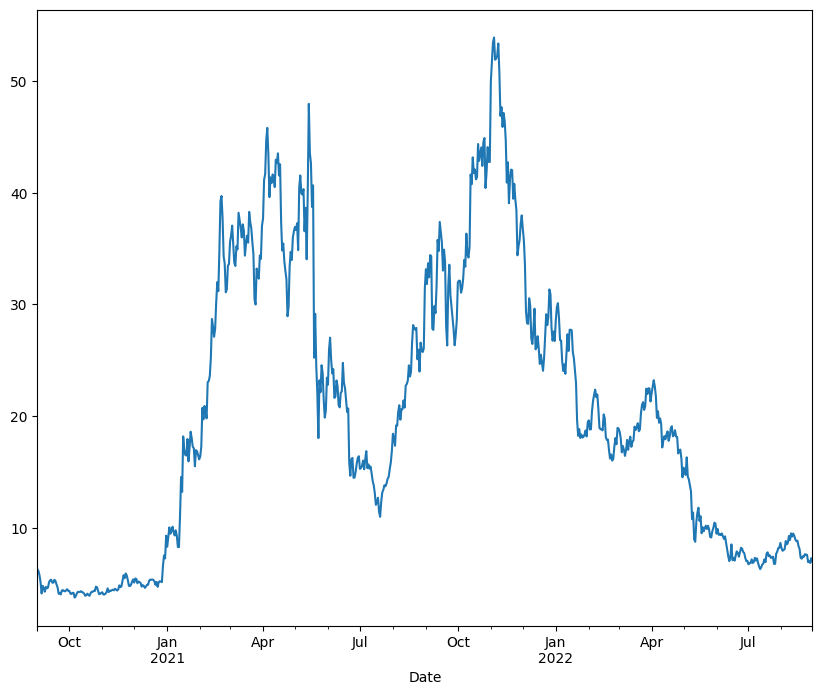

In [10]:
data_ac.plot(figsize=(10, 8), subplots=True)

array([<AxesSubplot: xlabel='Date'>], dtype=object)

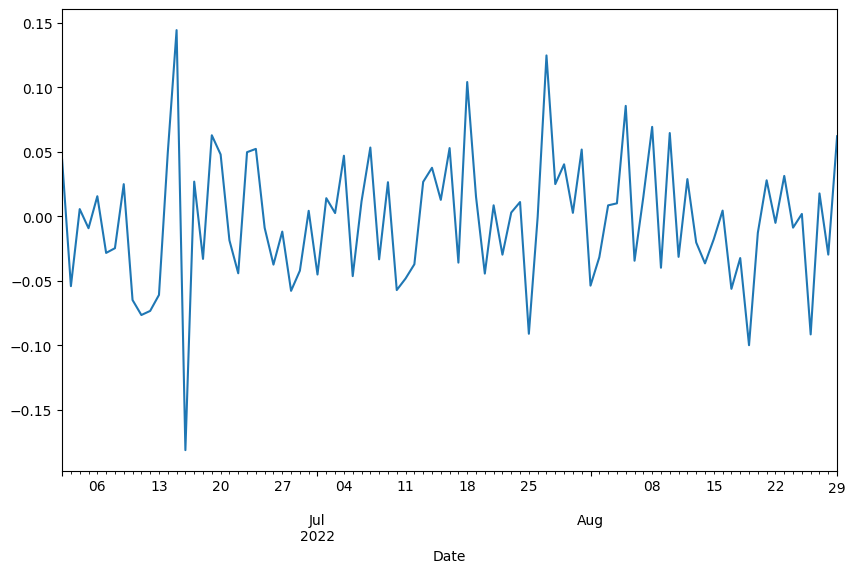

In [11]:
log_return.dropna(inplace=True)
log_return.plot(subplots=True, figsize=(10, 6))

In [312]:
data_vol = data_ac[-79:-73]
data_vol.head()

Date
2022-06-13    7.010198
2022-06-14    7.365457
2022-06-15    8.510279
2022-06-16    7.099977
2022-06-17    7.294320
Name: Adj Close, dtype: float64

In [313]:
print('The price on 15 Jun is fluctuate more than other days in the mention period.')

The price on 15 Jun is fluctuate more than other days in the mention period.


# Question 2

### Data input for Vanilla European put option

In [346]:
S0 = data_ac[-1:]     # spot price = 7.003431
K = 8                 # strike price
T = 1/52              # maturity 1 weeks
r = 0.03              # risk free rate 
sig = vol             # diffusion coefficient or volatility
N = 3                 # number of periods or number of time steps  
payoff = "put"        # payoff 

print(S0)

Date
2022-08-30    7.003431
Name: Adj Close, dtype: float64


### Binomial tree

1. Creating Binomial tree

In [347]:
dT = float(T) / N                    # Delta t
u = np.exp(sig * np.sqrt(dT))        # up factor
d = 1.0 / u                          # down factor 

S1 = np.zeros((N + 1, N + 1))
S1[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S1[i, t] = S1[i, t-1] * u
        S1[i+1, t] = S1[i, t-1] * d
    z += 1

In [348]:
print('The up factor u is ',(u))

The up factor u is  1.0810966366206685


In [349]:
print('The down factor d is ',(d))

The down factor d is  0.9249866904829495


In [350]:
print('The binomial tree presenting Polka Dot price over 3 time steps ', '\n', (S1))

The binomial tree presenting Polka Dot price over 3 time steps  
 [[7.00343084 7.57138553 8.18539943 8.84920779]
 [0.         6.47808032 7.00343084 7.57138553]
 [0.         0.         5.99213807 6.47808032]
 [0.         0.         0.         5.54264797]]


In [351]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
print('Risk-neutral porbability is ', (p))

Risk-neutral porbability is  0.48174788065919893


2. Option value at each final nodes

In [352]:
S_T = S1[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.42861447],
       [0.        , 0.        , 0.        , 1.52191968],
       [0.        , 0.        , 0.        , 2.45735203]])

3. Option value at earlier nodes

In [353]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
print('The option values at earlier nodes ', '\n', (V))

The option values at earlier nodes  
 [[1.08684563 0.62254736 0.22208764 0.        ]
 [0.         1.51884335 0.99503084 0.42861447]
 [0.         0.         2.00632361 1.52191968]
 [0.         0.         0.         2.45735203]]


In [354]:
print('Binomial tree & Option price - European ' + payoff, str( V[0,0]))

Binomial tree & Option price - European put 1.086845629364895


### Monte Carlo Simulation

In [374]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

In [375]:
S2 = mcs_simulation_np(1000)

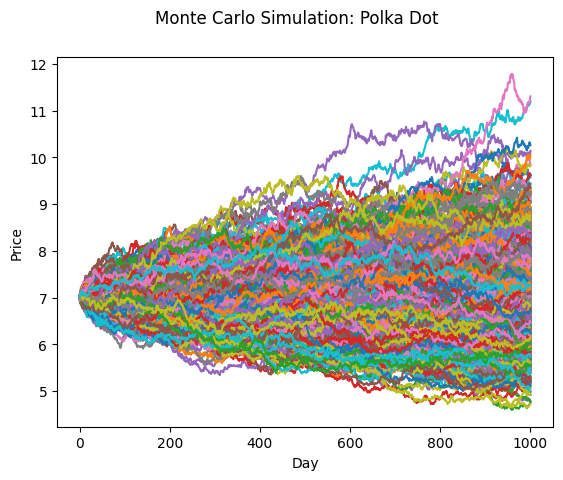

In [376]:
fig = plt.figure()
plt.plot(S2)
fig.suptitle('Monte Carlo Simulation: Polka Dot')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [377]:
S2 = np.transpose(S2)
S2

array([[7.00343084, 7.01824802, 6.97895726, ..., 8.54405861, 8.58107153,
        8.59031672],
       [7.00343084, 7.0258027 , 7.04220649, ..., 8.83173354, 8.87689559,
        8.91361046],
       [7.00343084, 7.05022294, 7.05701429, ..., 8.78637452, 8.8372721 ,
        8.80462132],
       ...,
       [7.00343084, 7.01370444, 6.97973241, ..., 7.96968588, 7.91564271,
        7.91789134],
       [7.00343084, 7.02495277, 7.04754761, ..., 6.08688657, 6.13316344,
        6.1730146 ],
       [7.00343084, 7.03851665, 7.03005938, ..., 7.25771172, 7.26582991,
        7.24105301]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

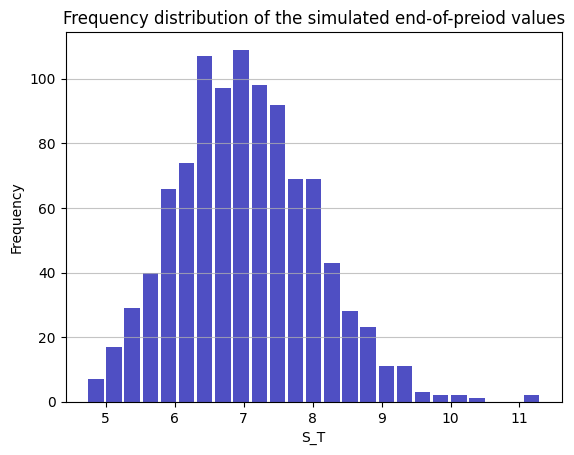

In [378]:
n, bins, patches = plt.hist(x=S2[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [379]:
put = np.mean(np.maximum(K - S2[:,-1],0))
print('Monte Carlo Simulation & Option price - European put', str(put))

Monte Carlo Simulation & Option price - European put 1.060309793515682


# Question 3

### Black-scholes option value

In [355]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [356]:
Bsm = euro_option_bsm(S0, K, T, r, 0, vol, 'put')            #q: dividend = 0
print('Black-scholes & Option price - European put', str(put))

Black-scholes & Option price - European put 1.071691337787539


### Delta

Delta, ∆, measures the rate of change of the theoretical option value with respect to changes in the underlying asset's price. Delta is the first derivative of the value V of the option with respect to the underlying instrument's price S.

In [272]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [291]:
delta(S0, K, T, r, 0, vol, 'put')

array([-0.81944862])

In [282]:
S11 = np.linspace(3,15,11)
Delta_Call = np.zeros((len(S11),1))
Delta_Put = np.zeros((len(S11),1))
for i in range(len(S11)):
    Delta_Put [i] = delta(S11[i], K, T, r, 0, vol, 'put')

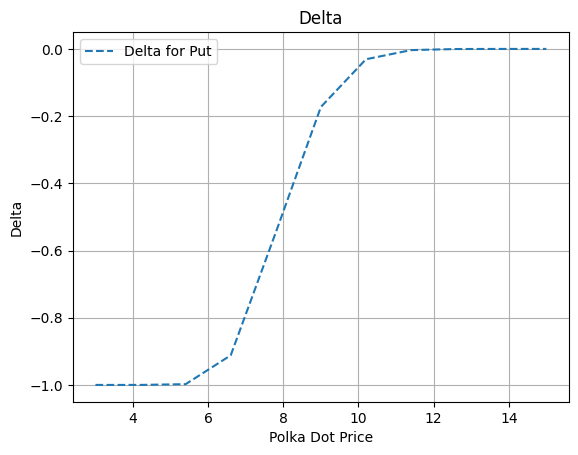

In [283]:
fig = plt.figure()

plt.plot(S11, Delta_Put, '--')
plt.grid()
plt.xlabel('Polka Dot Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

In [284]:
S12 = np.linspace(3, 15, 51)
T12 = np.linspace(3/365, 2/52, 51)
Delta1 = np.zeros((len(T12),len(S12)))
for j in range(len(S12)):
    for i in range(len(T12)):
        Delta1[i,j] = delta(S12[j], K, T12[i], r, 0, vol, 'put')

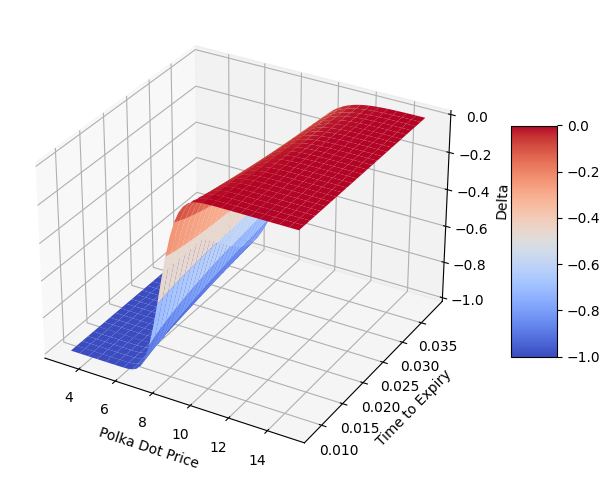

In [285]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S12, T12 = np.meshgrid(S12, T12)
surf = ax.plot_surface(S12, T12, Delta1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Polka Dot Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

### Gamma


Gamma, Γ, measures the rate of change in the delta with respect to changes in the underlying price. Gamma is the second derivative of the value function with respect to the underlying price.

In [286]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [290]:
gamma(S0, K, T, r, 0, vol, 'put')

Date
2022-08-30    0.277949
Name: Adj Close, dtype: float64

In [192]:
S21 = np.linspace(3,15,11)
Gamma1 = np.zeros((len(S21),1))
for i in range(len(S21)):
    Gamma1[i] = gamma(S21[i], K, T, r, 0, vol, 'put')

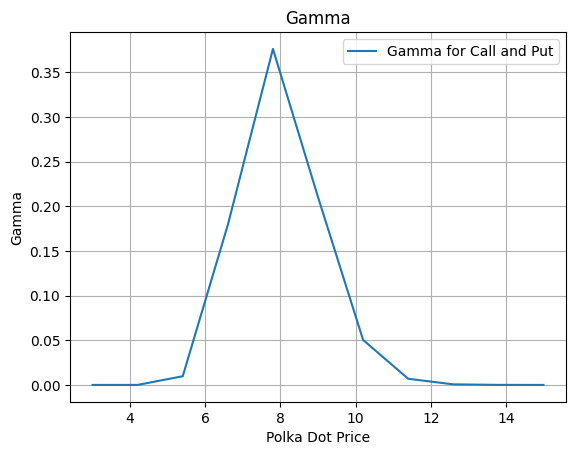

In [193]:
fig = plt.figure()
plt.plot(S21, Gamma1, '-')
plt.grid()
plt.xlabel('Polka Dot Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [194]:
S22 = np.linspace(3, 15, 51)
T22 = np.linspace(3/365, 2/52, 51)
Gamma1 = np.zeros((len(T22),len(S22)))
for j in range(len(S22)):
    for i in range(len(T22)):
        Gamma1[i,j] = gamma(S22[j], K, T22[i], r, 0, vol, 'put')

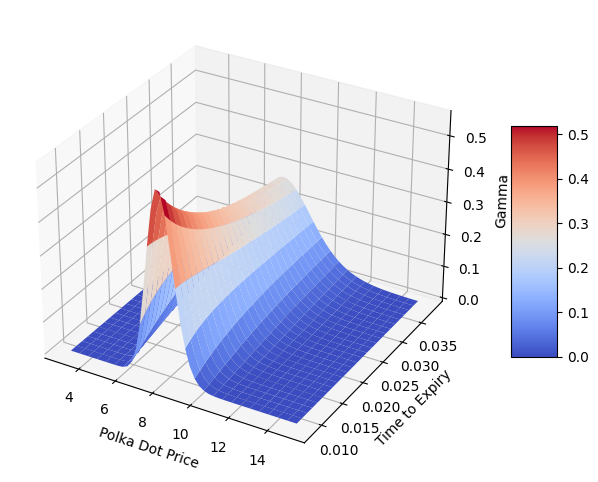

In [195]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S22, T22 = np.meshgrid(S22, T22)
surf = ax.plot_surface(S22, T22, Gamma1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Polka Dot Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

### Theta

Theta, 𝜃, measures the sensitivity of the value of the derivative to the passage of time (see Option time value): the "time decay".

In [200]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [201]:
theta(S0, K, T, r, 0, vol, 'put')

Date
2022-08-30    6.670054
Name: Adj Close, dtype: float64

In [221]:
T41 = np.linspace(1/52,1,51)
Theta_Call = np.zeros((len(T41),1))
Theta_Put = np.zeros((len(T41),1))
for i in range(len(T41)):
    Theta_Put [i] = theta(S0, K, T41[i], r, 0, vol, 'put')

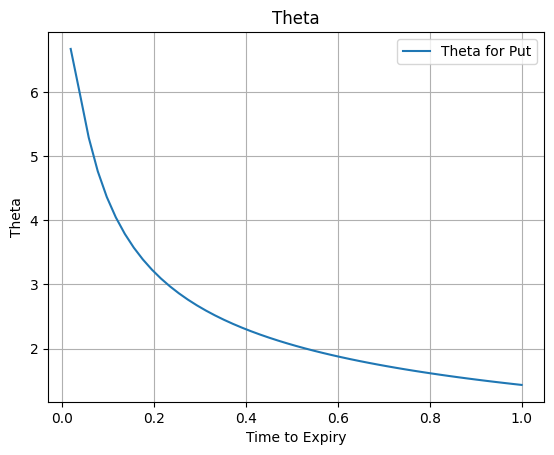

In [222]:
fig = plt.figure()
plt.plot(T41, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

In [227]:
S42 = np.linspace(3, 15, 51)
T42 = np.linspace(1/52, 3/52, 51)
Theta1 = np.zeros((len(T42),len(S42)))
for j in range(len(S42)):
    for i in range(len(T42)):
        Theta1[i,j] = theta(S42[j], K, T42[i], r, 0, vol, 'put')

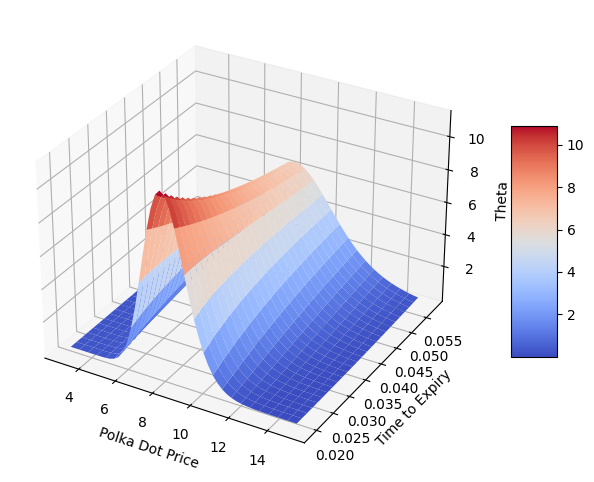

In [228]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S42, T42 = np.meshgrid(S42, T42)
surf = ax.plot_surface(S42, T42, Theta1, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Polka Dot Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

### Rho 

Rho, 𝜌, measures sensitivity to the interest rate: it is the derivative of the option value with respect to the risk free interest rate (for the relevant outstanding term).

In [292]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [293]:
rho(S0, K, T, r, 0, vol, 'put')

array([-0.13111746])

In [294]:
r1 = np.linspace(0.01,0.1,11)
Rho_Call = np.zeros((len(r1),1))
Rho_Put = np.zeros((len(r1),1))
for i in range(len(r1)):
    Rho_Put [i] = rho(S0, K, T, r1[i], 0, vol, 'put')

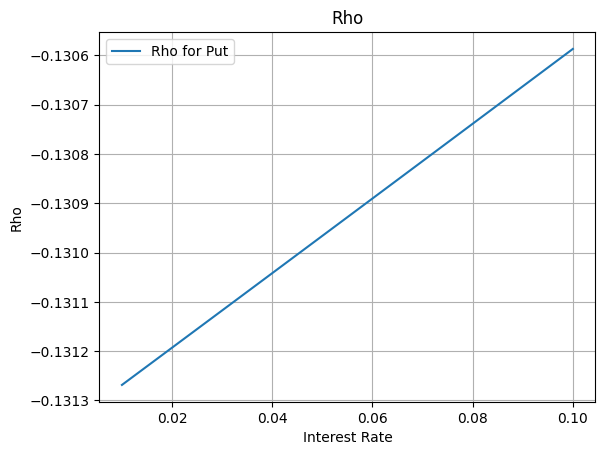

In [295]:
fig = plt.figure()
plt.plot(r1, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend([ 'Rho for Put'])

In [213]:
S53 = np.linspace(3, 15, 81)
T53 = np.linspace(3/365,2/52,81)
Rho3 = np.zeros((len(T53),len(S53)))
for j in range(len(S53)):
    for i in range(len(T53)):
        Rho3[i,j] = rho(S53[j], K, T53[i], r, 0, vol, 'put')

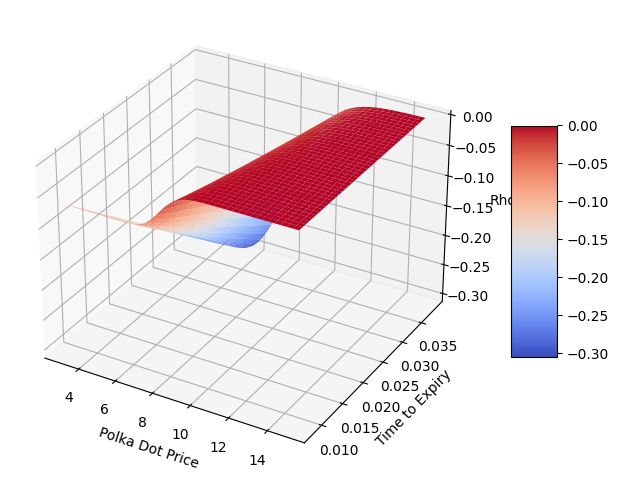

In [214]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S53, T53 = np.meshgrid(S53, T53)
surf = ax.plot_surface(S53, T53, Rho3, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Polka Dot Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

### Vega

Vega measures sensitivity to volatility. Vega is the derivative of the option value with respect to the volatility of the underlying asset.

In [301]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [302]:
vega(S0, K, T, r, 0, vol, 'put')

Date
2022-08-30    0.255333
Name: Adj Close, dtype: float64

In [298]:
volvega = np.linspace(0.5,1.5,13)
Vega = np.zeros((len(volvega),1))
for i in range(len(volvega)):
    Vega [i] = vega(S0, K, T, r, 0, volvega[i], 'put')

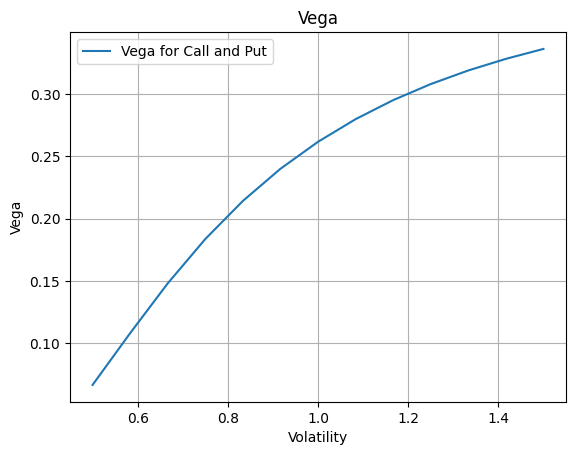

In [299]:
fig = plt.figure()
plt.plot(volvega, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [303]:
S63 = np.linspace(3, 15, 91)
T63 = np.linspace(3/365, 2/52, 91)
Vega2 = np.zeros((len(T63),len(S63)))
for j in range(len(S63)):
    for i in range(len(T63)):
        Vega2[i,j] = vega(S63[j], K, T63[i] , r, 0, vol, 'put')


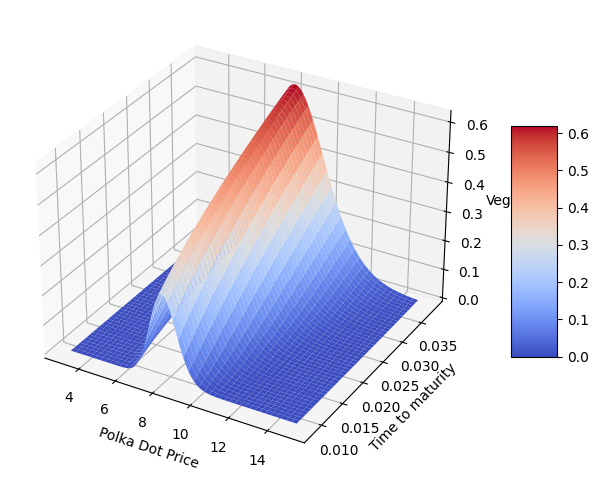

In [304]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
S63, T63 = np.meshgrid(S63,T63)
surf = ax.plot_surface(S63, T63, Vega2, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Polka Dot Price')
ax.set_ylabel('Time to maturity')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);